In [63]:
import pandas as pd
import requests
import datetime
import json
import numpy as np
import seaborn as sns
from numpy import array
from numpy import hstack
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
import os
def read_config(section, name=None, environment_variable=None, default=None, config_file_path='../../augur.config.json', no_config_file=0, use_main_config=0):
    """
    Read a variable in specified section of the config file, unless provided an environment variable

    :param section: location of given variable
    :param name: name of variable
    """
    _config_file_name = 'augur.config.json'
    _config_bad = False
    _already_exported = {}
    _runtime_location = 'runtime/'
    _default_config = {}
    _config_file = None

    try:
        _config_file = open(config_file_path, 'r+')
    except:
        print('Couldn\'t open {}'.format(_config_file_name))

    # Load the config file
    try:
        config_text = _config_file.read()
        _config = json.loads(config_text)
    except json.decoder.JSONDecodeError as e:
        if not _config_bad:
            _using_config_file = False
            print('{} could not be parsed, using defaults. Fix that file, or delete it and run this again to regenerate it. Error: {}'.format(config_file_path, str(e)))
        _config = _default_config

    value = None
    if environment_variable is not None:
        value = os.getenv(environment_variable)
    if value is None:
        try:
            if name is not None:
                value = _config[section][name]
            else:
                value = _config[section]
        except Exception as e:
            value = default
            if not section in _config:
                _config[section] = {}

    return value

In [124]:
augur_api_host = read_config("Server", "host", "AUGUR_HOST", "0.0.0.0",config_file_path='/Users/pratikmishra/augur/augur.config.json')
augur_api_port = read_config("Server", "port", "AUGUR_PORT", 5000,config_file_path='/Users/pratikmishra/augur/augur.config.json')

time_series = ['code-changes','code-changes-lines','issues-active','issues-closed',
              'contributors-new','reviews','issues-new',
              'open-issues-count','reviews-accepted','reviews-declined']
              
def time_series_metrics(repo_id):
    training_days = 365
    
    base_url = 'http://{}:{}/api/unstable/repo-groups/20/repos/{}/'.format(augur_api_host,augur_api_port,repo_id)
    begin_date = datetime.datetime(2019, 3, 31, 0, 0)#datetime.datetime.now().replace(hour=0, minute=0, second=0, microsecond=0) - datetime.timedelta(days=training_days)
    index = pd.date_range(begin_date, periods=training_days, freq='D')
    df = pd.DataFrame(index)
    df.columns = ['date']
    df['date'] = df['date'].astype(str)

    for endpoint in time_series:
        #print(endpoint)
        
        url = base_url + endpoint
        print("Hitting endpoint: " + url + "\n")
        try:
            data = requests.get(url=url).json()
            #print(data)
        except:
            data = json.loads(json.dumps(requests.get(url=url).text))

        if len(data) == 0:
            print("Endpoint with url: {} returned an empty response. Moving on to next endpoint.\n".format(url))
            continue
                    
        if 'date' not in data[0]:
            print("Endpoint {} is not a timeseries, moving to next endpoint.\n".format(endpoint))
            continue
                
        metric_df = pd.DataFrame.from_records(data)
        metric_df['date'] = pd.to_datetime(metric_df['date']).dt.date
        metric_df['date'] = metric_df['date'].astype(str)
        extra=['repo','rg','week','year']
        for column in metric_df.columns:
            if any(x in column for x in extra):
                metric_df.drop(column,axis=1,inplace=True)
                
        df = pd.DataFrame(pd.merge(df,metric_df.loc[:,metric_df.columns],how = 'left',on = 'date'))
        metric_df.drop('date',axis=1,inplace=True)
        df.rename(columns={i :"{} _ {}".format(endpoint, i) for i in metric_df.columns }, inplace=True)
    return df

## Highly Active Repo 

#### repo_id = 25563 , git url : 

In [66]:
data = time_series_metrics(25663)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25663/reviews-declined



In [67]:
data.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,106.0,393.0,147.0,5.0,5.0,5.0,NaN,7.0,NaN,NaN,NaN
1,2019-04-01,NaN,1109.0,647.0,NaN,11.0,2.0,2.0,4.0,6.0,NaN,1.0
2,2019-04-02,NaN,707.0,503.0,NaN,7.0,3.0,1.0,5.0,NaN,3.0,2.0
3,2019-04-03,NaN,1800.0,576.0,NaN,8.0,4.0,NaN,6.0,NaN,1.0,1.0
4,2019-04-04,NaN,793.0,409.0,2.0,6.0,3.0,1.0,13.0,NaN,1.0,1.0


In [68]:
data = data.fillna(0)

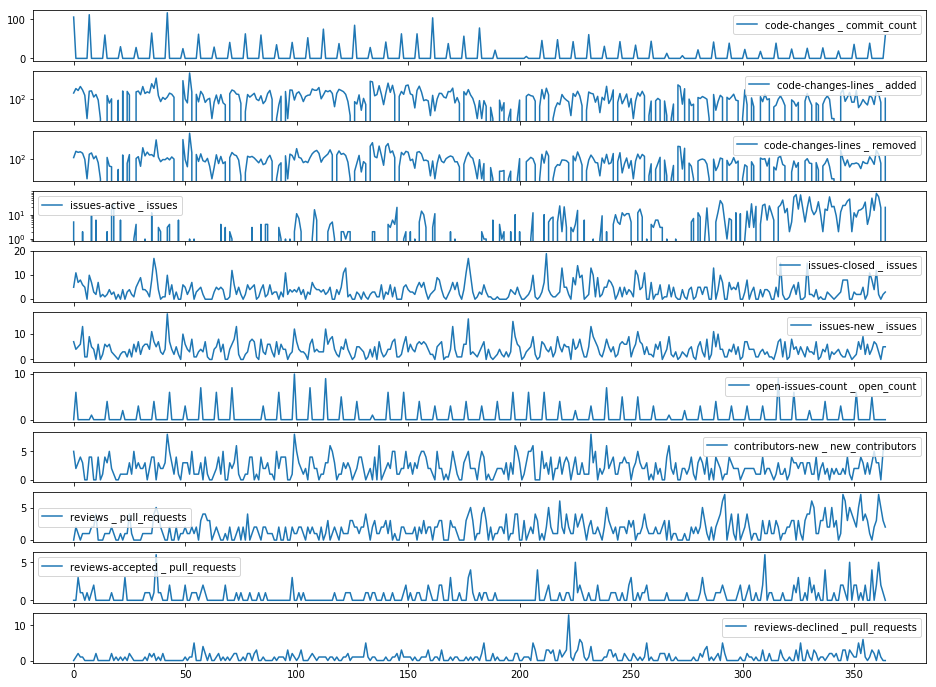

In [69]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data.iloc[:,1])
ax[1].plot(data.iloc[:,2])
ax[2].plot(data.iloc[:,3])
ax[3].plot(data.iloc[:,4])
ax[4].plot(data.iloc[:,5])
ax[5].plot(data.iloc[:,8])
ax[6].plot(data.iloc[:,9])
ax[7].plot(data.iloc[:,6])
ax[8].plot(data.iloc[:,7])
ax[9].plot(data.iloc[:,10])
ax[10].plot(data.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [70]:
data['date']=pd.to_datetime(data['date'].astype(str), format='%Y-%m-%d')

In [71]:
data2 = data.set_index('date').resample('w-mon', label='left').sum().reset_index()

In [72]:
data2.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-25,106.0,1502.0,794.0,5.0,16.0,7.0,2.0,11.0,6.0,0.0,1.0
1,2019-04-01,112.0,4776.0,2345.0,11.0,43.0,18.0,7.0,40.0,1.0,7.0,4.0
2,2019-04-08,60.0,727.0,521.0,8.0,18.0,12.0,8.0,23.0,4.0,2.0,2.0
3,2019-04-15,30.0,844.0,317.0,50.0,15.0,10.0,5.0,17.0,2.0,1.0,4.0
4,2019-04-22,28.0,1948.0,635.0,5.0,22.0,16.0,7.0,25.0,3.0,3.0,4.0


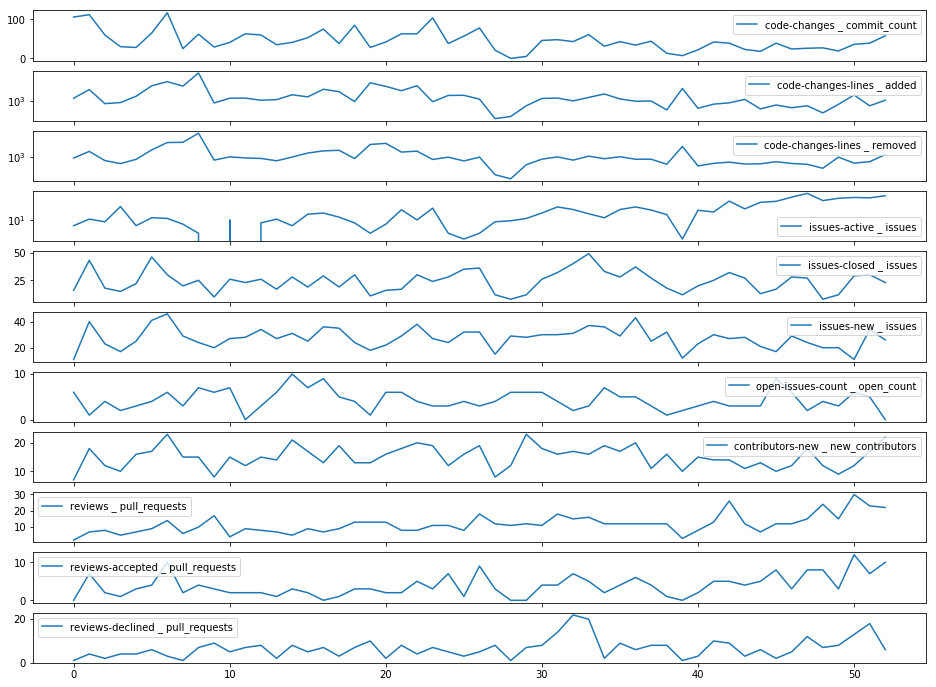

In [73]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data2.iloc[:,1])
ax[1].plot(data2.iloc[:,2])
ax[2].plot(data2.iloc[:,3])
ax[3].plot(data2.iloc[:,4])
ax[4].plot(data2.iloc[:,5])
ax[5].plot(data2.iloc[:,8])
ax[6].plot(data2.iloc[:,9])
ax[7].plot(data2.iloc[:,6])
ax[8].plot(data2.iloc[:,7])
ax[9].plot(data2.iloc[:,10])
ax[10].plot(data2.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [74]:
data3 = data.set_index('date').resample('m', label='left').sum().reset_index()

In [75]:
data3

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-02-28,106.0,393.0,147.0,5.0,5.0,5.0,0.0,7.0,0.0,0.0,0.0
1,2019-03-31,230.0,9669.0,4484.0,74.0,118.0,60.0,29.0,111.0,16.0,13.0,15.0
2,2019-04-30,269.0,73194.0,70488.0,33.0,114.0,73.0,53.0,149.0,20.0,23.0,25.0
3,2019-05-31,228.0,5691.0,3268.0,25.0,100.0,57.0,29.0,123.0,16.0,7.0,22.0
4,2019-06-30,207.0,13610.0,8731.0,68.0,119.0,77.0,34.0,141.0,37.0,7.0,26.0
5,2019-07-31,218.0,28614.0,19687.0,51.0,68.0,69.0,51.0,106.0,17.0,12.0,29.0
6,2019-08-31,340.0,9321.0,4045.0,51.0,135.0,72.0,50.0,128.0,17.0,22.0,20.0
7,2019-09-30,72.0,3691.0,1877.0,64.0,83.0,69.0,55.0,114.0,22.0,10.0,32.0
8,2019-10-31,183.0,6435.0,2923.0,124.0,151.0,71.0,60.0,138.0,16.0,18.0,59.0
9,2019-11-30,141.0,8231.0,7366.0,117.0,100.0,64.0,43.0,126.0,16.0,13.0,23.0


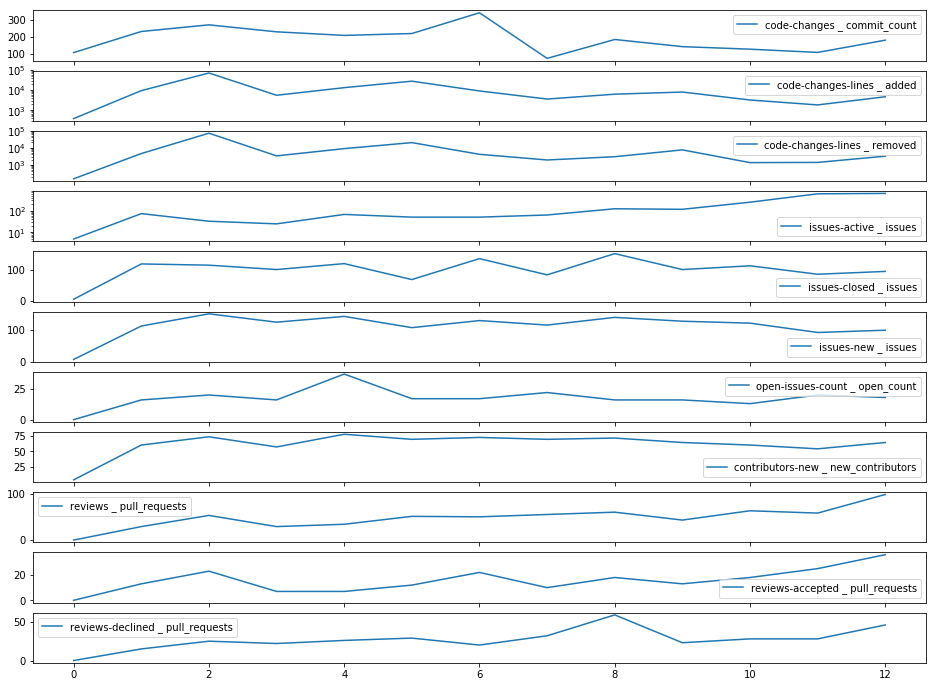

In [76]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(data3.iloc[:,1])
ax[1].plot(data3.iloc[:,2])
ax[2].plot(data3.iloc[:,3])
ax[3].plot(data3.iloc[:,4])
ax[4].plot(data3.iloc[:,5])
ax[5].plot(data3.iloc[:,8])
ax[6].plot(data3.iloc[:,9])
ax[7].plot(data3.iloc[:,6])
ax[8].plot(data3.iloc[:,7])
ax[9].plot(data3.iloc[:,10])
ax[10].plot(data3.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

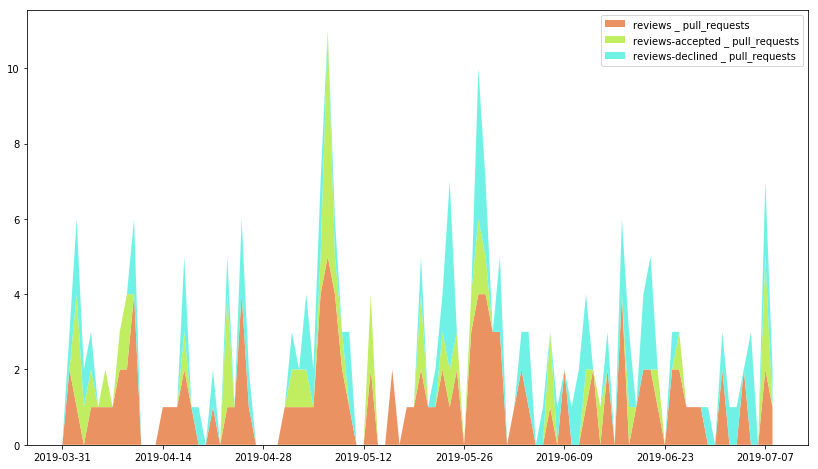

In [77]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(data[:100]['date'].values,data[:100]['reviews _ pull_requests'], data[:100]['reviews-accepted _ pull_requests'],
              data[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

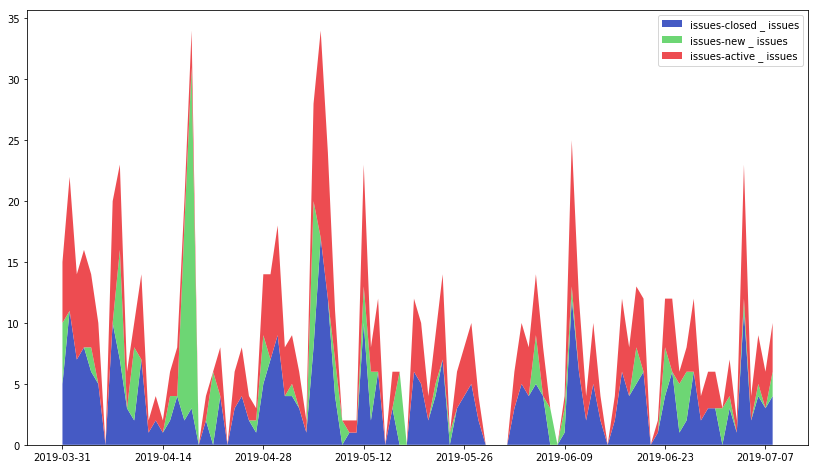

In [78]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(data[:100]['date'].values,data[:100]['issues-closed _ issues'], data[:100]['issues-active _ issues'],data[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [79]:
data = data.groupby(data['date']).sum()

In [80]:
data.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,6.591781,462.569863,352.928767,5.753425,3.517808,2.178082,1.706849,3.978082,0.624658,0.558904,0.967123
std,18.825994,2399.156258,2512.705234,11.076632,3.473263,1.683325,1.509706,3.019090,1.731716,1.002721,1.376416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,16.000000,6.000000,0.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,91.000000,54.000000,1.000000,3.000000,2.000000,1.000000,4.000000,0.000000,0.000000,1.000000
75%,0.000000,309.000000,165.000000,6.000000,5.000000,3.000000,2.000000,6.000000,0.000000,1.000000,1.000000
max,117.000000,42297.000000,45525.000000,75.000000,19.000000,8.000000,7.000000,18.000000,10.000000,6.000000,13.000000


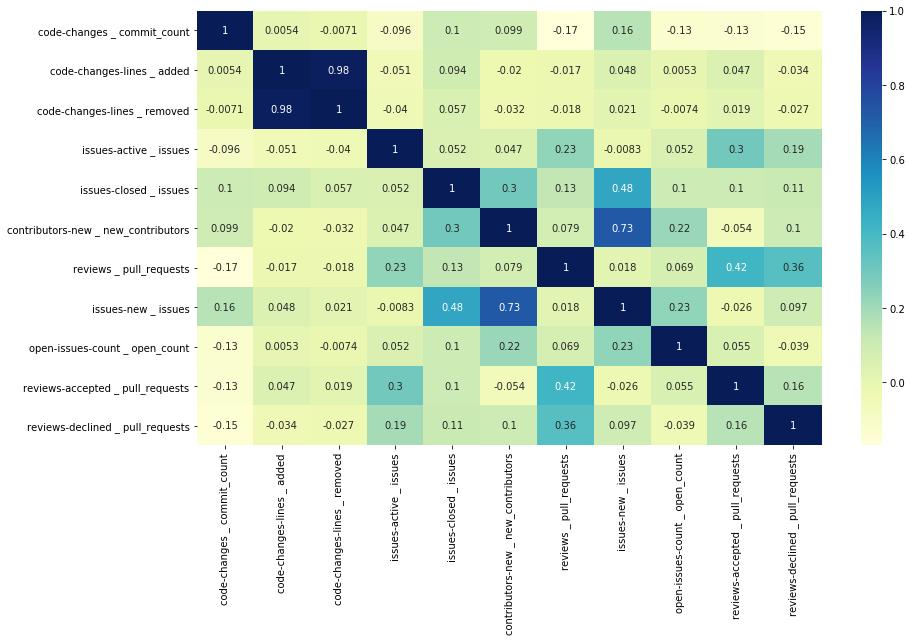

In [81]:
plt.figure(figsize=(14,8))
sns.heatmap(data.corr(), cmap="YlGnBu",annot=True)

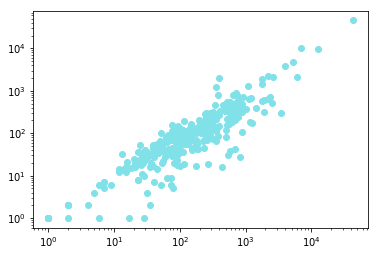

In [82]:
fig,ax=plt.subplots()
labels = ['code-changes-lines _ added','code-changes-lines _ removed']
colors = ['#80e1e8','#8182e6']
ax.plot(data['code-changes-lines _ added'],data['code-changes-lines _ removed'],'o',label=labels,color = '#80e1e8')

ax.set_yscale('log')
ax.set_xscale('log')

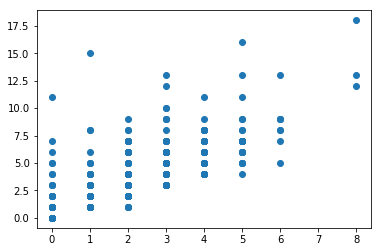

In [83]:
fig,ax=plt.subplots()
ax.plot(data['contributors-new _ new_contributors'],data['issues-new _ issues'],'o')


## Moderately Active Repo

#### repo_id = 25797   git url  : https://github.com/Spring-projects/spring-session

In [85]:
df = time_series_metrics(25797)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/25797/reviews-declined



In [86]:
df.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,6.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN
1,2019-04-01,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,1.0,10.0,3.0
2,2019-04-02,NaN,NaN,NaN,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN
3,2019-04-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df = df.fillna(0)

In [88]:
df.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,10.0,3.0
2,2019-04-02,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
df['date']=pd.to_datetime(df['date'].astype(str), format='%Y-%m-%d')

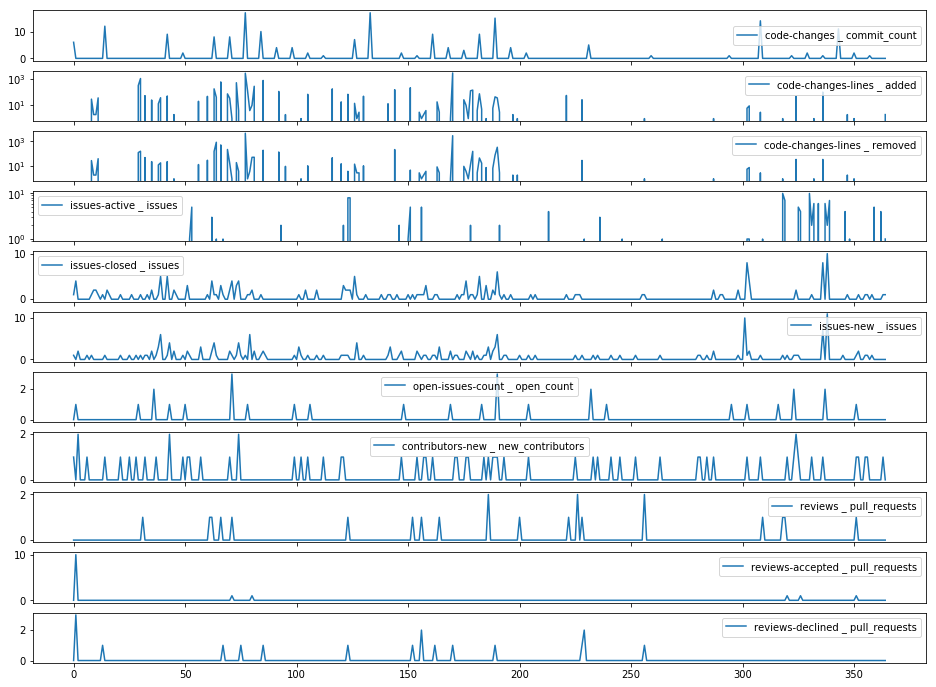

In [99]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df.iloc[:,1])
ax[1].plot(df.iloc[:,2])
ax[2].plot(df.iloc[:,3])
ax[3].plot(df.iloc[:,4])
ax[4].plot(df.iloc[:,5])
ax[5].plot(df.iloc[:,8])
ax[6].plot(df.iloc[:,9])
ax[7].plot(df.iloc[:,6])
ax[8].plot(df.iloc[:,7])
ax[9].plot(df.iloc[:,10])
ax[10].plot(df.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [100]:
df2 = df.set_index('date').resample('w-mon', label='left').sum().reset_index()

In [101]:
df2.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-25,6.0,0.0,0.0,0.0,5.0,1.0,0.0,1.0,1.0,10.0,3.0
1,2019-04-01,0.0,29.0,29.0,0.0,1.0,3.0,0.0,4.0,0.0,0.0,0.0
2,2019-04-08,12.0,40.0,45.0,0.0,8.0,1.0,0.0,1.0,0.0,0.0,1.0
3,2019-04-15,0.0,0.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0
4,2019-04-22,0.0,304.0,128.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,0.0


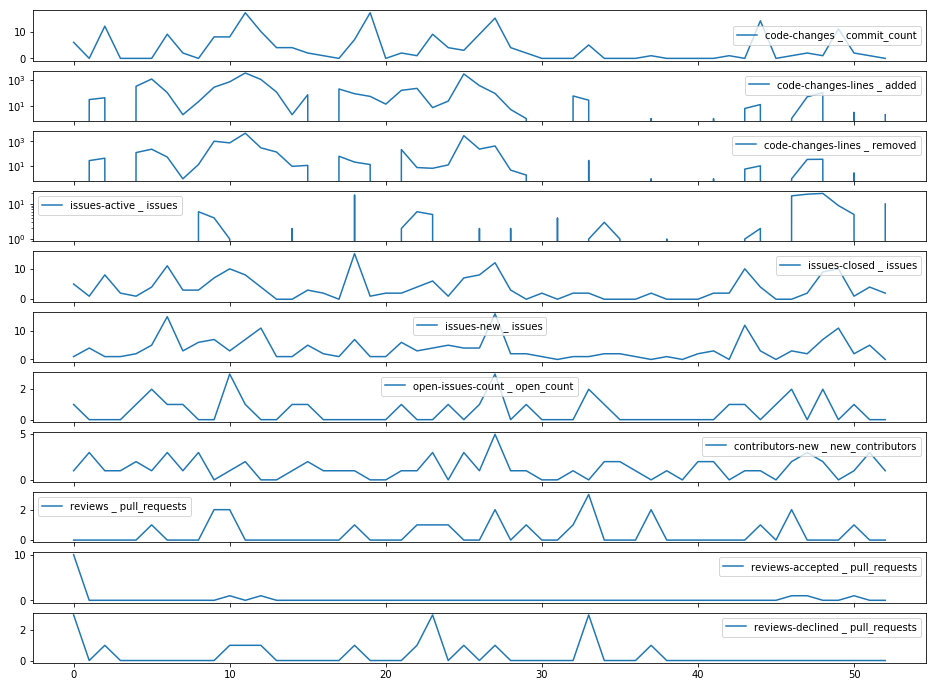

In [102]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df2.iloc[:,1])
ax[1].plot(df2.iloc[:,2])
ax[2].plot(df2.iloc[:,3])
ax[3].plot(df2.iloc[:,4])
ax[4].plot(df2.iloc[:,5])
ax[5].plot(df2.iloc[:,8])
ax[6].plot(df2.iloc[:,9])
ax[7].plot(df2.iloc[:,6])
ax[8].plot(df2.iloc[:,7])
ax[9].plot(df2.iloc[:,10])
ax[10].plot(df2.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [103]:
df3 = df.set_index('date').resample('m', label='left').sum().reset_index()

In [104]:
df3

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-02-28,6.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
1,2019-03-31,12.0,1401.0,366.0,0.0,17.0,7.0,0.0,9.0,2.0,10.0,4.0
2,2019-04-30,11.0,247.0,177.0,6.0,21.0,8.0,2.0,28.0,4.0,0.0,0.0
3,2019-05-31,47.0,5132.0,6711.0,5.0,28.0,3.0,3.0,29.0,4.0,2.0,3.0
4,2019-06-30,7.0,369.0,229.0,4.0,10.0,6.0,0.0,11.0,2.0,0.0,0.0
5,2019-07-31,26.0,503.0,264.0,24.0,17.0,1.0,2.0,13.0,1.0,0.0,2.0
6,2019-08-31,26.0,3101.0,3171.0,7.0,24.0,8.0,2.0,20.0,2.0,0.0,4.0
7,2019-09-30,21.0,92.0,441.0,6.0,17.0,7.0,3.0,21.0,4.0,0.0,1.0
8,2019-10-31,5.0,81.0,30.0,4.0,4.0,4.0,4.0,5.0,3.0,0.0,3.0
9,2019-11-30,1.0,1.0,1.0,2.0,2.0,3.0,2.0,3.0,0.0,0.0,1.0


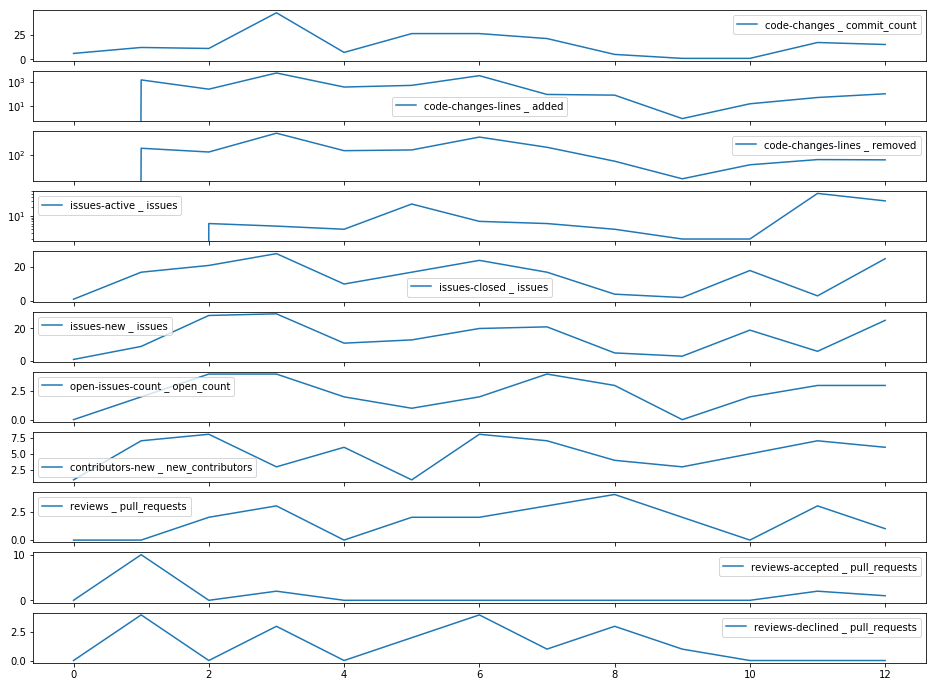

In [105]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df3.iloc[:,1])
ax[1].plot(df3.iloc[:,2])
ax[2].plot(df3.iloc[:,3])
ax[3].plot(df3.iloc[:,4])
ax[4].plot(df3.iloc[:,5])
ax[5].plot(df3.iloc[:,8])
ax[6].plot(df3.iloc[:,9])
ax[7].plot(df3.iloc[:,6])
ax[8].plot(df3.iloc[:,7])
ax[9].plot(df3.iloc[:,10])
ax[10].plot(df3.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

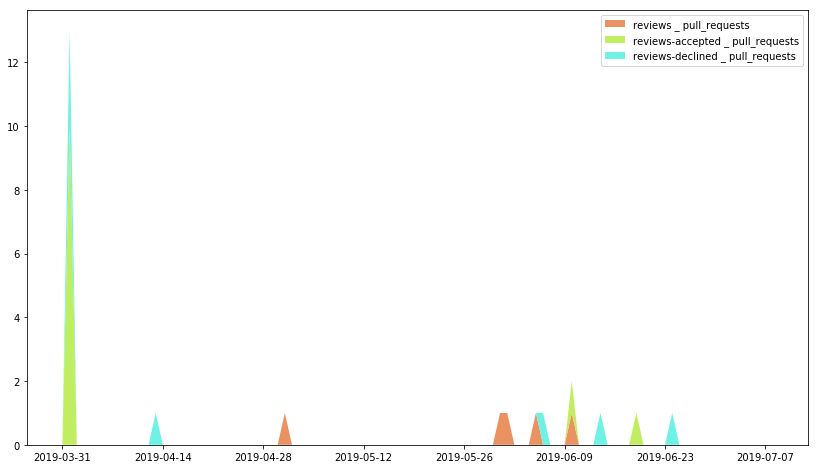

In [106]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(df[:100]['date'].values,df[:100]['reviews _ pull_requests'], df[:100]['reviews-accepted _ pull_requests'],
              df[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

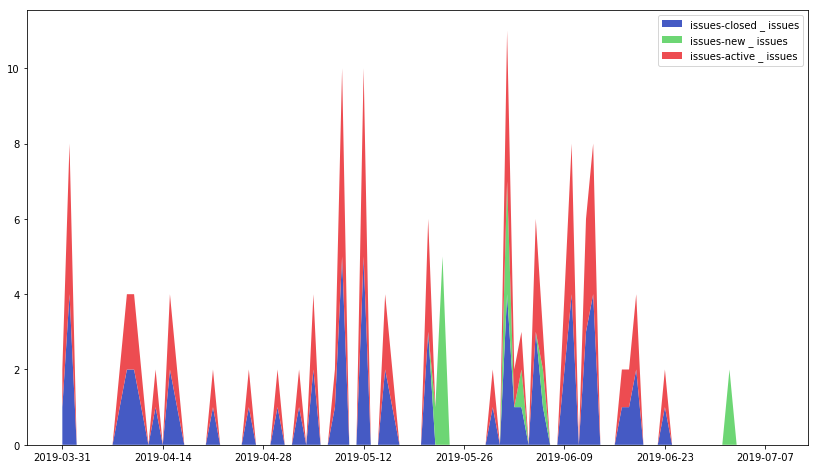

In [107]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(df[:100]['date'].values,df[:100]['issues-closed _ issues'], df[:100]['issues-active _ issues'],df[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [108]:
df = df.groupby(df['date']).sum()

In [109]:
df.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.534247,30.408219,31.465753,0.386301,0.512329,0.180822,0.060274,0.520548,0.082192,0.041096,0.049315
std,2.251265,211.009428,289.569901,1.412786,1.221594,0.412929,0.270703,1.225973,0.361370,0.535507,0.272918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,17.000000,2688.000000,4595.000000,10.000000,10.000000,2.000000,2.000000,11.000000,3.000000,10.000000,3.000000


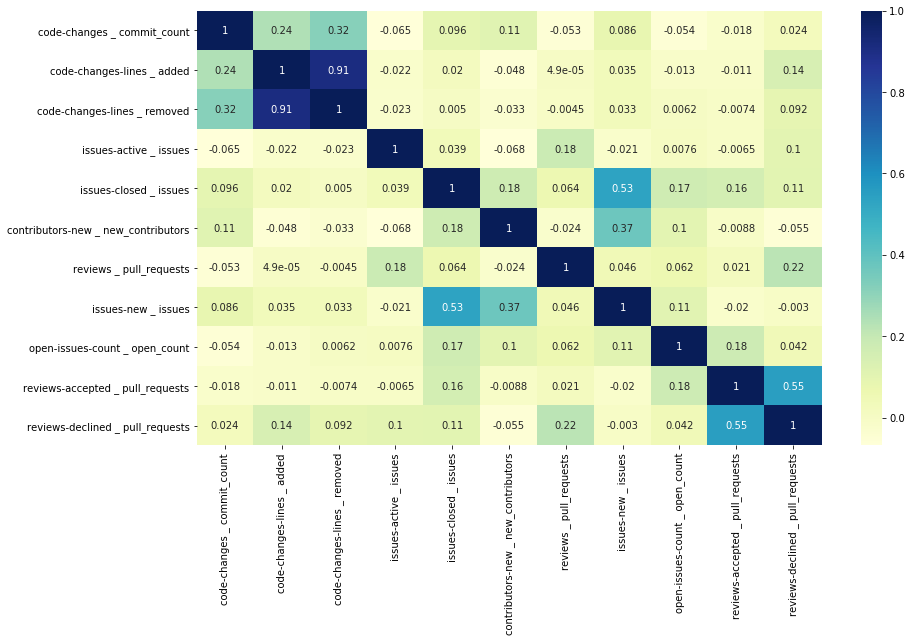

In [110]:
plt.figure(figsize=(14,8))
sns.heatmap(df.corr(), cmap="YlGnBu",annot=True)

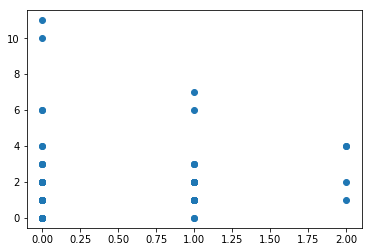

In [111]:
fig,ax=plt.subplots()
ax.plot(df['contributors-new _ new_contributors'],df['issues-new _ issues'],'o')

## Less Active Repo

#### repo_id = 30001 git url : https://github.com/projectcontour/gimbal

In [125]:
df_frame = time_series_metrics(30001)

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/code-changes-lines

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-active

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-closed

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/contributors-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/issues-new

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/open-issues-count

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-accepted

Hitting endpoint: http://0.0.0.0:5153/api/unstable/repo-groups/20/repos/30001/reviews-declined



In [126]:
df_frame.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-02,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,2019-04-03,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [127]:
df_frame = df_frame.fillna(0)

In [128]:
df_frame.head()

,date,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
0,2019-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-04-02,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,2019-04-03,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
df_frame['date']=pd.to_datetime(df_frame['date'].astype(str), format='%Y-%m-%d')

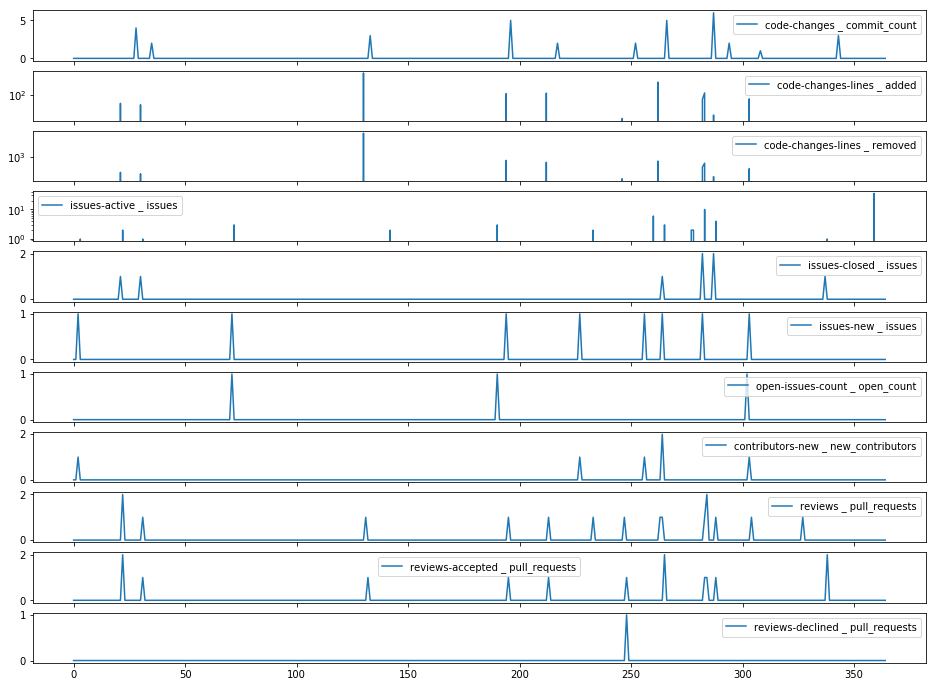

In [130]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame.iloc[:,1])
ax[1].plot(df_frame.iloc[:,2])
ax[2].plot(df_frame.iloc[:,3])
ax[3].plot(df_frame.iloc[:,4])
ax[4].plot(df_frame.iloc[:,5])
ax[5].plot(df_frame.iloc[:,8])
ax[6].plot(df_frame.iloc[:,9])
ax[7].plot(df_frame.iloc[:,6])
ax[8].plot(df_frame.iloc[:,7])
ax[9].plot(df_frame.iloc[:,10])
ax[10].plot(df_frame.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [131]:
df_frame2 = df_frame.set_index('date').resample('w-mon', label='left').sum().reset_index()

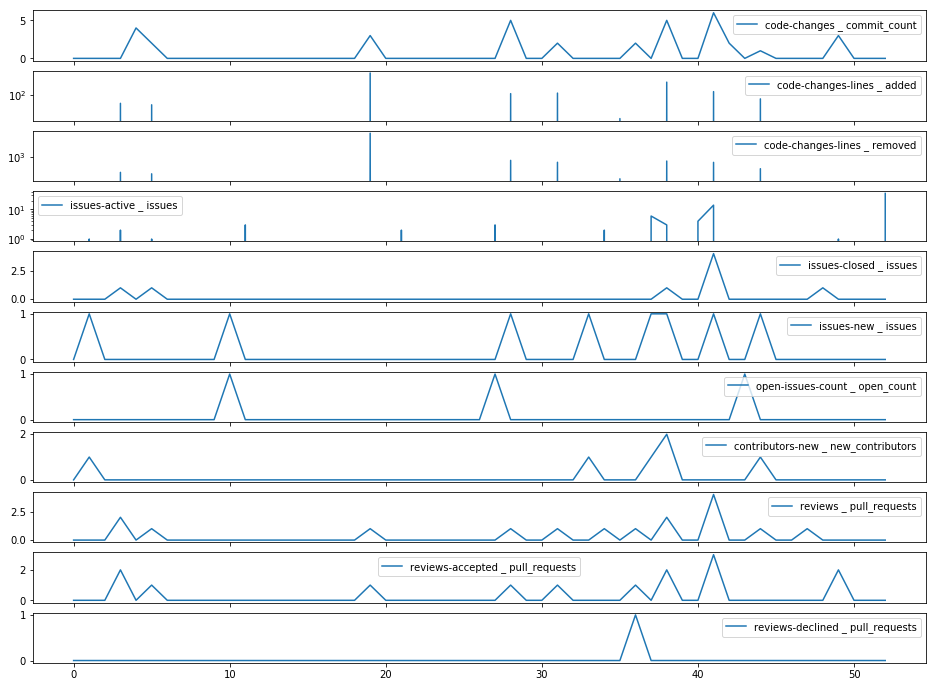

In [133]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame2.iloc[:,1])
ax[1].plot(df_frame2.iloc[:,2])
ax[2].plot(df_frame2.iloc[:,3])
ax[3].plot(df_frame2.iloc[:,4])
ax[4].plot(df_frame2.iloc[:,5])
ax[5].plot(df_frame2.iloc[:,8])
ax[6].plot(df_frame2.iloc[:,9])
ax[7].plot(df_frame2.iloc[:,6])
ax[8].plot(df_frame2.iloc[:,7])
ax[9].plot(df_frame2.iloc[:,10])
ax[10].plot(df_frame2.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

In [134]:
df_frame3 = df_frame.set_index('date').resample('m', label='left').sum().reset_index()

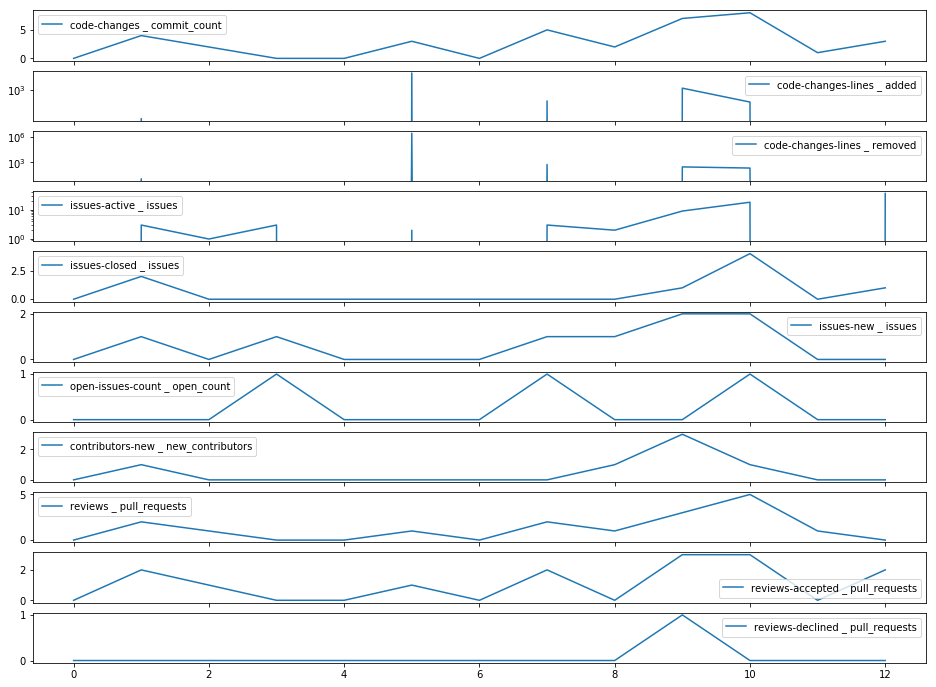

In [135]:
fig,ax = plt.subplots(11,1,figsize=(16,12),sharex=True)

ax[0].plot(df_frame3.iloc[:,1])
ax[1].plot(df_frame3.iloc[:,2])
ax[2].plot(df_frame3.iloc[:,3])
ax[3].plot(df_frame3.iloc[:,4])
ax[4].plot(df_frame3.iloc[:,5])
ax[5].plot(df_frame3.iloc[:,8])
ax[6].plot(df_frame3.iloc[:,9])
ax[7].plot(df_frame3.iloc[:,6])
ax[8].plot(df_frame3.iloc[:,7])
ax[9].plot(df_frame3.iloc[:,10])
ax[10].plot(df_frame3.iloc[:,11])

ax[1].set_yscale('log')
ax[2].set_yscale('log')
ax[3].set_yscale('log')



ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[3].legend()
ax[4].legend()
ax[5].legend()
ax[6].legend()
ax[7].legend()
ax[8].legend()
ax[9].legend()
ax[10].legend()

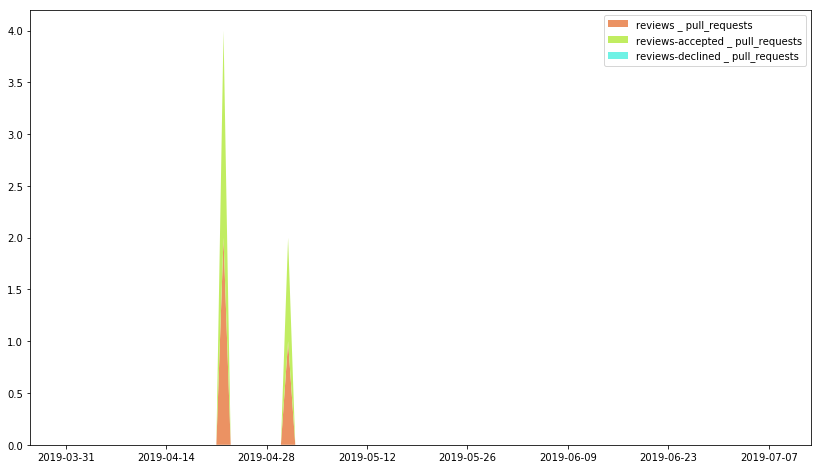

In [136]:
plt.figure(figsize=(14,8))
labels=['reviews _ pull_requests','reviews-accepted _ pull_requests','reviews-declined _ pull_requests']
colors = ['#eb9263','#c1ed61','#6ff2e5']
plt.stackplot(df_frame[:100]['date'].values,df_frame[:100]['reviews _ pull_requests'], df_frame[:100]['reviews-accepted _ pull_requests'],
              df_frame[:100]['reviews-declined _ pull_requests'],labels=labels,colors=colors)
plt.legend()

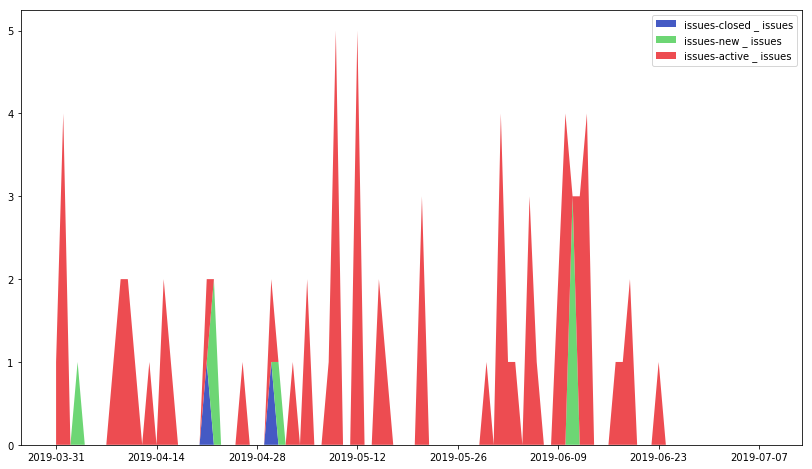

In [137]:
plt.figure(figsize=(14,8))
labels=['issues-closed _ issues','issues-new _ issues','issues-active _ issues']
colors = ['#455ac4','#6dd674','#ed4c51']
plt.stackplot(df_frame[:100]['date'].values,df_frame[:100]['issues-closed _ issues'], df_frame[:100]['issues-active _ issues'],df[:100]['issues-closed _ issues'],
              labels=labels,colors=colors)
plt.legend()

In [138]:
df_frame = df_frame.groupby(df_frame['date']).sum()

In [139]:
df.describe()

,code-changes _ commit_count,code-changes-lines _ added,code-changes-lines _ removed,issues-active _ issues,issues-closed _ issues,contributors-new _ new_contributors,reviews _ pull_requests,issues-new _ issues,open-issues-count _ open_count,reviews-accepted _ pull_requests,reviews-declined _ pull_requests
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.534247,30.408219,31.465753,0.386301,0.512329,0.180822,0.060274,0.520548,0.082192,0.041096,0.049315
std,2.251265,211.009428,289.569901,1.412786,1.221594,0.412929,0.270703,1.225973,0.361370,0.535507,0.272918
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,17.000000,2688.000000,4595.000000,10.000000,10.000000,2.000000,2.000000,11.000000,3.000000,10.000000,3.000000


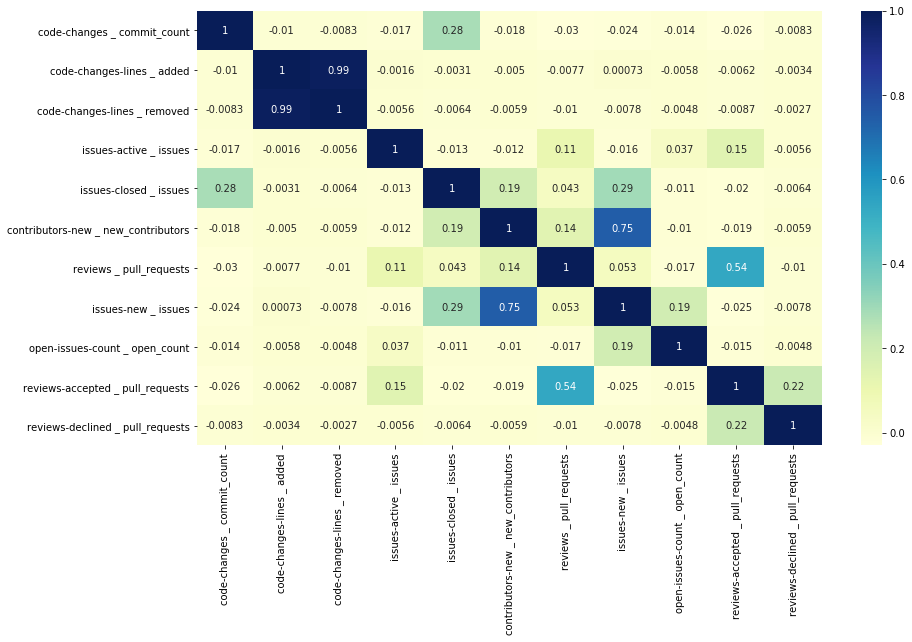

In [140]:
plt.figure(figsize=(14,8))
sns.heatmap(df_frame.corr(), cmap="YlGnBu",annot=True)

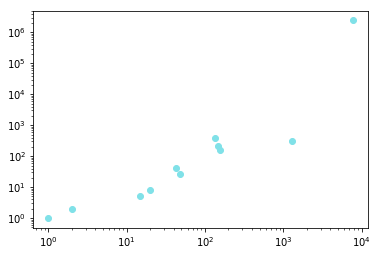

In [141]:
fig,ax=plt.subplots()
labels = ['code-changes-lines _ added','code-changes-lines _ removed']
colors = ['#80e1e8','#8182e6']
ax.plot(df_frame['code-changes-lines _ added'],df_frame['code-changes-lines _ removed'],'o',label=labels,color = '#80e1e8')

ax.set_yscale('log')
ax.set_xscale('log')